In [1]:
######################preferential synthetic data(disperate impact)################
import math
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

def generate_synthetic_data(plot_data=False):

    """
        Code for generating the synthetic data.
        We will have two non-sensitive features and one sensitive feature.
        A sensitive feature value of 0.0 means the example is considered to be in protected group (e.g., female) and 1.0 means it's in non-protected group (e.g., male).
    """

    n_samples = 2000 # generate these many data points per class
    disc_factor = math.pi / 4.0 # this variable determines the initial discrimination in the data -- decraese it to generate more discrimination

    def gen_gaussian(mean_in, cov_in, class_label):
        nv = multivariate_normal(mean = mean_in, cov = cov_in)
        X = nv.rvs(n_samples)
        y = np.ones(n_samples, dtype=float) * class_label
        return nv,X,y

    """ Generate the non-sensitive features randomly """
    # We will generate one gaussian cluster for each class
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    nv1, X1, y1 = gen_gaussian(mu1, sigma1, 1) # positive class
    nv2, X2, y2 = gen_gaussian(mu2, sigma2, -1) # negative class

    # join the posisitve and negative class clusters
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))
    
    # shuffle the data
    perm = [*range(0,n_samples*2)]

    shuffle(perm)
    X = X[perm]
    y = y[perm]
    
    rotation_mult = np.array([[math.cos(disc_factor), -math.sin(disc_factor)], [math.sin(disc_factor), math.cos(disc_factor)]])
    X_aux = np.dot(X, rotation_mult)


    """ Generate the sensitive feature here """
    x_control = [] # this array holds the sensitive feature value
    for i in range (0, len(X)):
        x = X_aux[i]

        # probability for each cluster that the point belongs to it
        p1 = nv1.pdf(x)
        p2 = nv2.pdf(x)
        
        # normalize the probabilities from 0 to 1
        s = p1+p2
        p1 = p1/s
        p2 = p2/s
        
        r = np.random.uniform() # generate a random number from 0 to 1

        if r < p1: # the first cluster is the positive class
            x_control.append(1.0) # 1.0 means its male
        else:
            x_control.append(0.0) # 0.0 -> female

    x_control = np.array(x_control)

    """ Show the data """
    if plot_data:
        num_to_draw = 200 # we will only draw a small number of points to avoid clutter
        x_draw = X[:num_to_draw]
        y_draw = y[:num_to_draw]
        x_control_draw = x_control[:num_to_draw]

        X_s_0 = x_draw[x_control_draw == 0.0]
        X_s_1 = x_draw[x_control_draw == 1.0]
        y_s_0 = y_draw[x_control_draw == 0.0]
        y_s_1 = y_draw[x_control_draw == 1.0]
        plt.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='green', marker='x', s=30, linewidth=1.5, label= "Prot. +ve")
        plt.scatter(X_s_0[y_s_0==-1.0][:, 0], X_s_0[y_s_0==-1.0][:, 1], color='red', marker='x', s=30, linewidth=1.5, label = "Prot. -ve")
        plt.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='green', marker='o', facecolors='none', s=30, label = "Non-prot. +ve")
        plt.scatter(X_s_1[y_s_1==-1.0][:, 0], X_s_1[y_s_1==-1.0][:, 1], color='red', marker='o', facecolors='none', s=30, label = "Non-prot. -ve")

        
        plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') # dont need the ticks to see the data distribution
        plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
        plt.legend(loc=2, fontsize=15)
        plt.xlim((-15,10))
        plt.ylim((-10,15))
#         plt.show()
#       plt.savefig("img/data.png")
        
#     x_control = {"s1": x_control} # all the sensitive features are stored in a dictionary
    return X,y,x_control

def Synth_data():
    X,y,x_control=generate_synthetic_data(True)
    X=np.column_stack((X,x_control))
    print(X)
    print(y)
    return(X,y)








In [2]:
############################---LP4--with epsilon-with accuracy-########################
#############----Synthetic MIN Max COMMAND----###################### 
def min_max_lp_all(data,eps,r):
    x1 = np.zeros((1, 1400), dtype = float)
    x1=data[0:1400,2]
    print(x1.shape[0])
    
    n=1400
    R = np.zeros((2, n), dtype = int)
    for i in range(n):
        if x1[i]== 1:
            R[0][i]= 1
        else:
            R[1][i]= 1
    m=2
    n=1400 

    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
    print(range(n)) 
    #X[n]=z() n last value of X
    X=np.zeros(n+1,dtype=p.LpVariable)
    Y=np.zeros(n,dtype=p.LpVariable)
    #X[]=0 to n-1

    for i in range(n):
        var1=str(i)
        var2=str(i+n+2)
        X[i]=p.LpVariable(var1,lowBound=0,upBound=1,cat='Integer')
        Y[i]=p.LpVariable(var2,lowBound=0)
        
    X[n] =  p.LpVariable("z1",lowBound=0)
  

    #########objective function#####################
    
    Lp_prob += X[n] + p.lpSum([Y[j] for j in range(n)])

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*R[i][j] for j in range(n)])
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*R[i-m][j] for j in range(n)])
            
    for i in range(2*n):
        if i<n:
            Lp_prob += Y[i] >= X[i]-r[i]
        else:        
            Lp_prob += Y[i-n] >= -1*(X[i-n]-r[i-n])       
    ##### r(y_train values real labels of data)
    
  

    Lp_prob += X[n] >=eps
    Lp_prob += X[n] <=1300
    
    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")
    x=0
    for i in range(n):
        x=x+p.value(Y[j])
        
    w=p.value(X[n])
    print(w) # The solution status 
    Synth1={}
    Synth2={}
    # # Printing the final solution 
    for i in range(n):
        if(p.value(X[i])==1):
            Synth1[i]=1 
            Synth2[i]=-1
        else:
            Synth1[i]=-1
            Synth2[i]=1
    Synthu1=Synth1  
    Synthu2=Synth2  
#     print("LP")
#     print((Lp_prob))  
    return Synthu1,Synthu2    
 







In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%pylab inline
from random import *
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
def Synth_svm(data,label):
   
    X = data
    y = label
    print(y)



    #Split data into training and test datasets (training will be based on 70% of data)
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,shuffle=False) 
    #test_size: if integer, number of examples into test dataset; if between 0.0 and 1.0, means proportion
    print('There are {} samples in the training set and {} samples in the test set'.format(X_train.shape[0], X_test.shape[0]))


    #Scaling data
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score

    sc = StandardScaler(with_mean=False)
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)

    #X_train_std and X_test_std are the scaled datasets to be used in algorithms

    #Applying SVC (Support Vector Classification)
    from sklearn.svm import SVC

    svm = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
    svm.fit(X_train_std, y_train)
    print('The accuracy of the SVM classifier on training data is {:.2f}'.format(svm.score(X_train_std, y_train)))
    print('The accuracy of the SVM classifier on test data is {:.2f}'.format(svm.score(X_test_std, y_test)))
    print('####Train prediction Label###############################################')
    y_1=svm.predict(X_train_std)
    print(y_1)

    # print(y_1[2:3])
    # print(y_1[3:4])
    # print(y_1[4:5])
    # for i in range(X_train.shape[0]):
    #      print(y_1[i])


    print('####Actual Train Label###############################################')
    # print(y_train)

    # y_train.to_numpy()

    # for i in range(X_train.shape[0]):
    #     print(y_train[i])

    ###############################################
    print('####Change to colors###############################################')
    count=0
    for i in range(X_train.shape[0]):
        if y_1[i] == y_train[i]:
            count=count+1
    # print(count)    

    # y_trainx=np.zeros((1,X_train.shape[0]),dtype= int)

    # for i in range(X_train.shape[0]):
    #     if y_train[i]==1:
    #         y_trainx[i]=-1
    #     else:
    #         y_trainx[i]=1



    # for i in range(X_train.shape[0]):
    #     if y_1[i]==1:
    #         y_1x[i]=-1
    #     else:
    #         y_1x[i]=1



    # print('####Test###############################################')
    # y_2=svm.predict(X_test_std)
    return y_1,y_train

Populating the interactive namespace from numpy and matplotlib


/home/subham/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed', 'multivariate_normal', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:

import time
import pulp as p 
import numpy as np
def min_max_lp_all(data,gamma,eps):
    pq=data.shape[0]
    data1=np.zeros((2,pq),dtype=int)
    for i in range(data.shape[0]):
        if(data[i]==0):   
            data1[0][i]=0
            data1[1][i]=1 
        else : 
            data1[0][i]=1
            data1[1][i]=0     
    
    print(data1)
    
    
    m=data1.shape[0]
    n=data1.shape[1]
      
    print('dimension of data')
    print(m,n)
    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
   
    #X[n]=z() n last value of X
    X=np.zeros(n+2,dtype=p.LpVariable)
#     X=np.zeros(n+1,dtype=p.LpVariable)
    
    sizess=np.zeros(m,dtype=int)
    
    for i in range(m):
        count=0
        for j in range(n):
            if data1[i][j]==1:
                count=count+1
                
        sizess[i]=count
    #X[]=0 to n-1

    for i in range(n):
        var1=str(i)
        
        X[i]=p.LpVariable(var1,lowBound=0,upBound=1,cat='Integer')
       
        
    X[n] =  p.LpVariable("z1",lowBound=0)
    X[n+1] =  p.LpVariable("z2",lowBound=0)

    #########objective function#####################
#     Lp_prob += X[n]
    Lp_prob += X[n] +X[n+1]

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)])
            Lp_prob += p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)]) >= (2*gamma-1)*sizess[i]
            Lp_prob += p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)]) <= ((2*gamma-1)+eps)*sizess[i]
            
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*data1[i-m][j] for j in range(n)])
            
         
    ##### r(y_train values real labels of data)
    Lp_prob += X[n+1] >= p.lpSum([2*(X[j]-0.5)-r[j] for j in range(n)])
    Lp_prob += X[n+1] >= p.lpSum([-1*2*(X[j]-0.5)+r[j] for j in range(n)])
        
#     epsilon=.01
    #n1 is the number of elements in sensitive attribute 
           
       
    Lp_prob += X[n] <= 42000
    
    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")        
    print(p.value(Lp_prob.objective))
    x=np.zeros(n,dtype=float)
#     for i in range(n):
#         x[i]=p.value(X[i])
#     for i in range(n):
#         print(x)
   # The solution status 
    Synth1={}
    Synth2={}
    # # Printing the final solution 
    for i in range(n):
        if(p.value(X[i])==1):
            Synth1[i]=1 
            Synth2[i]=-1
        else:
            Synth1[i]=-1
            Synth2[i]=1
    Synthu1=Synth1  
    Synthu2=Synth2  
    
              
    return Synthu1,Synthu2   


[[ 0.8166893   2.24923534  1.        ]
 [-4.15725038 -0.80738314  1.        ]
 [ 4.04993892 -1.20482092  0.        ]
 ...
 [-4.6817629  -1.80201809  1.        ]
 [ 5.16890565  2.18722718  0.        ]
 [-7.03217161 -1.51778045  0.        ]]
[ 1. -1.  1. ... -1.  1. -1.]
[ 1. -1.  1. ... -1.  1. -1.]
There are 2800 samples in the training set and 1200 samples in the test set
The accuracy of the SVM classifier on training data is 0.88
The accuracy of the SVM classifier on test data is 0.90
####Train prediction Label###############################################
[ 1. -1. -1. ...  1.  1. -1.]
####Actual Train Label###############################################
####Change to colors###############################################
bhai
4000
actual
2800
total males,female
1293 1507
total male select,not select
934 359
total female select,not select
429 1078
2800
bhai bhai
2800
actual
2800
total males,female
1293 1507
total 1select
0.7223511214230471
total2select
0.2846715328467153
[[1 1 0 ... 

NameError: name 'r' is not defined

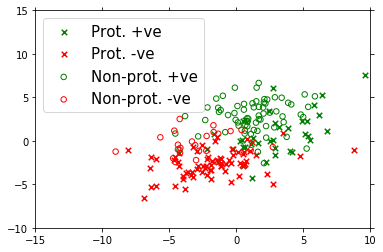

In [9]:
#####################-----LP-epsilon---##################3
import pandas as pd
import pulp as p 
import math
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data
# SEED = 1122334455
# print("x3 ndim: ", x3.ndim)
# print("x3 shape:", x3.shape)
# print("x3 size: ", x3.size)
# seed(SEED) # set the random seed so that the random permutations can be reproduced again
# np.random.seed(SEED)

data1,y=Synth_data()
# print(data.shape[0])
# print(data.shape[1])
y_train,y_1=Synth_svm(data1,y)
#####################################################
n=data1.shape[0]
print('bhai')
print(n)
Ms=0
Mns=0
Fs=0
Fns=0
for j in range(y_train.shape[0]):
        if(data1[j][2]==1 and y_train[j]==1):
            Ms+=1       

        if(data1[j][2]==1 and y_train[j]==-1):
            Mns+=1

        if(data1[j][2]==0 and y_train[j]==1):
            Fs+=1       
        if(data1[j][2]==0 and y_train[j]==-1):
            Fns+=1


######################################################
print("actual")
ALL=0
ALL=Ms+Mns+Fs+Fns
print(ALL)
print("total males,female")
M=0
F=0
M=Ms+Mns
F=Fs+Fns
print(M,F)
print("total male select,not select")
print(Ms,Mns)
print("total female select,not select")
print(Fs,Fns)




count1=0
count2=0
n=int(0.7*n)
print(n)
print('bhai bhai')

data=data1[:n,:]
print(data.shape[0])



Ms=0
Mns=0
Fs=0
Fns=0
for j in range(data.shape[0]):
        if(data[j][2]==1 and y_train[j]==1):
            Ms+=1       

        if(data[j][2]==1 and y_train[j]==-1):
            Mns+=1

        if(data[j][2]==0 and y_train[j]==1):
            Fs+=1       
        if(data[j][2]==0 and y_train[j]==-1):
            Fns+=1


######################################################
print("actual")
ALL=0
ALL=Ms+Mns+Fs+Fns
print(ALL)
print("total males,female")
M=0
F=0
a=Ms+Mns
b=Fs+Fns
print(a,b)
print("total 1select")
print(Ms/a)
print("total2select")
print(Fs/b)






gamma=.35
eps=0.05
u1,u2=min_max_lp_all(data[:,2],gamma,eps)

fi=np.zeros(n,dtype=int)
ci=[]
for alpha in np.arange(0,1.05,0.05) :
    count1=0
    count2=0
    acc1=0
    acc2=0
    f_acc=0
    for i in range(n):
        z=random()
            
        if z < alpha:
                fi[i]= int(u1[i]) 
                #count=count+1
        else:
               fi[i]= int(y_1[i])

    for i in range(n):
         if fi[i] == y_train[i]:
                f_acc=f_acc+1


    f_acc_percent=f_acc/n  
    ci.append(f_acc_percent)

    for i in range(n):
        if data[i,2]== 1 and fi[i]==1:
                acc1=acc1+1
        if data[i,2]== 0 and fi[i]==1:
                acc2=acc2+1                     
        

    
    a1=float(acc1/a)
    b1=float(acc2/b)
   
   
    print(acc1,acc2)
    print(a1,b1)          

print(ci)

